In [1]:
import os
import librosa
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Load data

In [2]:
annotation_data = pd.read_csv('../data/annotations-dev.csv', low_memory=False).sort_values('audio_filename')
annotation_data.shape

(10349, 70)

In [3]:
annotation_data.sample(5)

,split,sensor_id,audio_filename,annotator_id,1-1_small-sounding-engine_presence,1-2_medium-sounding-engine_presence,1-3_large-sounding-engine_presence,1-X_engine-of-uncertain-size_presence,2-1_rock-drill_presence,2-2_jackhammer_presence,...,7-X_other-unknown-human-voice_proximity,8-1_dog-barking-whining_proximity,1_engine_presence,2_machinery-impact_presence,3_non-machinery-impact_presence,4_powered-saw_presence,5_alert-signal_presence,6_music_presence,7_human-voice_presence,8_dog_presence
4339,train,27,27_002082.wav,598,0.0,0.0,0.0,0.0,0.0,0.0,...,-1,-1,0,0,0.0,1,0,0,0,0
6129,train,37,37_003076.wav,1376,0.0,0.0,0.0,0.0,0.0,0.0,...,-1,-1,0,0,0.0,0,0,0,0,0
8903,validate,6,06_000048.wav,-1,0.0,0.0,0.0,0.0,-1.0,-1.0,...,-1,-1,0,-1,-1.0,-1,-1,-1,-1,-1
10170,validate,6,06_000619.wav,0,0.0,1.0,1.0,0.0,0.0,0.0,...,-1,-1,1,0,0.0,0,0,0,0,0
9715,validate,0,00_000765.wav,-5,-1.0,-1.0,-1.0,-1.0,0.0,0.0,...,-1,-1,-1,0,0.0,-1,-1,-1,-1,-1


# Class distribution

In [4]:
(annotation_data.copy()
 .loc[lambda x: x.split == 'train']
 .set_index('audio_filename')
 .filter(regex='.*_presence$', axis='columns')
 .rename(columns=lambda x: x[:-9])
 .astype('int64').shape)

(7053, 37)

In [5]:
annotation_data.copy().loc[lambda x: x.split == 'train'].audio_filename.drop_duplicates().shape

(2351,)

In [6]:
tmp = annotation_data.copy().loc[lambda x: x.split == 'train']

# total number of rows
tmp.shape[0]
# number of files
tmp.audio_filename.drop_duplicates().shape[0]

tmp = (tmp
       .set_index('audio_filename')
       .filter(regex='.*_presence$', axis='columns')
       .rename(columns=lambda x: x[:-9])
       .astype('int64'))

tmp = (tmp
       .reset_index()
       .melt('audio_filename')
       .loc[lambda x: x.value == 1]
       .groupby('variable')['audio_filename']
       .agg(lambda x: np.unique(x).shape[0]))

7053

2351

In [7]:
from plotnine import *

In [8]:
coarse = tmp.filter(regex='^[0-9]_[a-z]+', axis='rows').reset_index()

In [17]:
list(reversed(coarse.variable.tolist()))

['8_dog',
 '7_human-voice',
 '6_music',
 '5_alert-signal',
 '4_powered-saw',
 '3_non-machinery-impact',
 '2_machinery-impact',
 '1_engine']

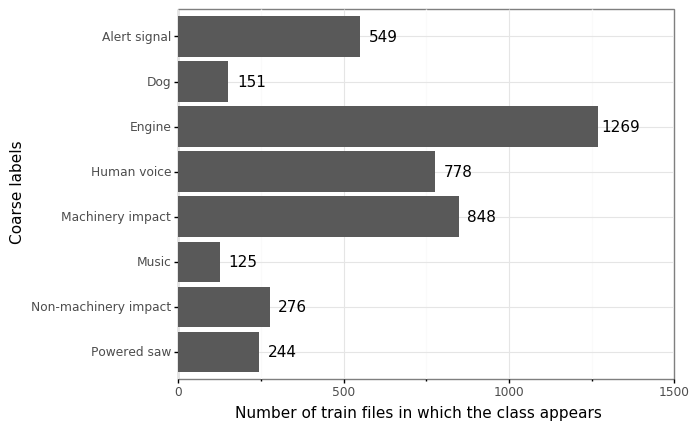

<ggplot: (8734272870333)>

In [19]:
(ggplot(coarse.assign(label_pos=lambda x: x.audio_filename +70))
 + geom_col(aes('variable', 'audio_filename'))
 + coord_flip()
 + geom_text(aes('variable', 'label_pos', label='audio_filename'))
 + theme_bw()
 + scale_y_continuous(expand=(0, 0), limits=(0, 1500))
 + scale_x_discrete(
     limits=['4_powered-saw','3_non-machinery-impact','6_music',
             '2_machinery-impact','7_human-voice',
             '1_engine','8_dog','5_alert-signal'],
     labels=['Powered saw','Non-machinery impact','Music',
             'Machinery impact','Human voice',
             'Engine','Dog','Alert signal'])
 + xlab('Coarse labels')
 + ylab('Number of train files in which the class appears')
)

In [10]:
fine = tmp.filter(regex='^[0-9]-[0-9]_[a-z]+', axis='rows').reset_index()

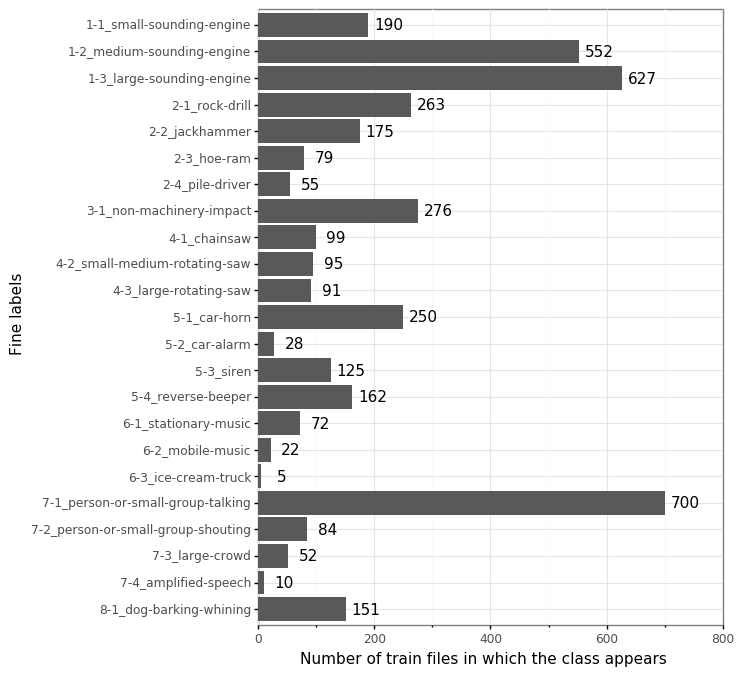

<ggplot: (8747210670377)>

In [11]:
(ggplot(fine.assign(label_pos=lambda x: x.audio_filename + 35))
 + geom_col(aes('variable', 'audio_filename'))
 + coord_flip()
 + geom_text(aes('variable', 'label_pos', label='audio_filename'))
 + theme_bw()
 + theme(figure_size=(6, 8))
 + scale_y_continuous(expand=(0, 0), limits=(0, 800))
 + scale_x_discrete(limits=list(reversed(fine.variable.tolist())))
 + xlab('Fine labels')
 + ylab('Number of train files in which the class appears')
)

# Annotations - Train vs validation sets

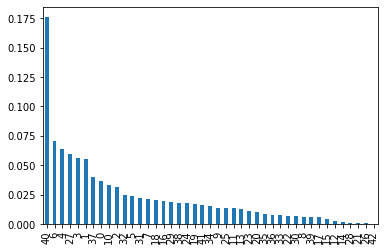

In [12]:
annotation_data.sensor_id.value_counts(normalize=True).plot.bar();

Sensor ID sets are disjoint between training and test

---

In [13]:
(annotation_data
 .assign(is_annotator_zooniverse=lambda x: x.annotator_id > 0)
 .groupby(['split', 'audio_filename', 'is_annotator_zooniverse'])['annotator_id'].count().reset_index()
 .rename({'annotator_id': 'num_annotations'})
 .drop(columns='audio_filename')
 .drop_duplicates())

,split,is_annotator_zooniverse,annotator_id
0,train,True,3
2351,validate,False,19
2352,validate,True,3
2353,validate,False,5
2355,validate,False,7
2361,validate,False,3
2373,validate,False,9
2773,validate,False,11


Zooniverse citizen science volunteers did both train and validation sets, but SONYC team members did only  validation set.

----

In [14]:
len(annotation_data.annotator_id.unique())

555

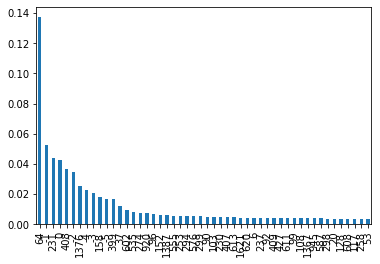

In [15]:
annotation_data.annotator_id.value_counts(normalize=True).head(50).plot.bar();

In [16]:
len(annotation_data.loc[lambda x: x.split == 'train'].annotator_id.unique())
len(annotation_data.loc[lambda x: x.split == 'validate'].annotator_id.unique())
len(set(annotation_data.loc[lambda x: x.split == 'train'].annotator_id.tolist()).intersection(
    set(annotation_data.loc[lambda x: x.split == 'validate'].annotator_id.tolist())))

530

307

282

# Taxonomy

In [17]:
with open('../data/dcase-ust-taxonomy.yaml', 'r') as f:
    taxonomy = yaml.load(f, Loader=yaml.Loader)

In [18]:
file_list = annotation_data['audio_filename'].unique().tolist()

full_fine_target_labels = ["{}-{}_{}".format(coarse_id, fine_id, fine_label)
                           for coarse_id, fine_dict in taxonomy['fine'].items()
                           for fine_id, fine_label in fine_dict.items()]

fine_target_labels = [x
                      for x in full_fine_target_labels
                      if x.split('_')[0].split('-')[1] != 'X']

coarse_target_labels = ["_".join([str(k), v])
                        for k,v in taxonomy['coarse'].items()]

In [19]:
tmp1 = pd.DataFrame.from_records([
    (key1, key2, val2)
    for key1, val1 in taxonomy['fine'].items()
    for key2, val2 in val1.items()
], columns=['coarse_id', 'fine_id', 'fine'])
tmp2 = pd.DataFrame.from_records([
    (key, val)
    for key, val in taxonomy['coarse'].items()
], columns=['coarse_id', 'coarse'])
taxonomy_df = pd.merge(tmp1, tmp2, on='coarse_id', how='inner')
taxonomy_df = taxonomy_df.astype('str')
taxonomy_df['coarse'] = taxonomy_df.coarse_id + '_' + taxonomy_df.coarse
taxonomy_df['fine'] = taxonomy_df.coarse_id + '-' +\
                      taxonomy_df.fine_id + '_' + taxonomy_df.fine

In [20]:
taxonomy_df

,coarse_id,fine_id,fine,coarse
0,1,1,1-1_small-sounding-engine,1_engine
1,1,2,1-2_medium-sounding-engine,1_engine
2,1,3,1-3_large-sounding-engine,1_engine
3,1,X,1-X_engine-of-uncertain-size,1_engine
4,2,1,2-1_rock-drill,2_machinery-impact
5,2,2,2-2_jackhammer,2_machinery-impact
6,2,3,2-3_hoe-ram,2_machinery-impact
7,2,4,2-4_pile-driver,2_machinery-impact
8,2,X,2-X_other-unknown-impact-machinery,2_machinery-impact
9,3,1,3-1_non-machinery-impact,3_non-machinery-impact
